--------

In [18]:
import os
import glob
import zipfile

import cv2
from PIL import Image

import numpy as np
import random

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import normalize
from keras.optimizers import Adam

2023-10-25 19:23:03.128458: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 19:23:03.128505: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 19:23:03.130046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 19:23:03.225242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
image_directory = 'Data/train/Images/'
mask_directory = 'Data/train/Masks/'

In [20]:
image_names = glob.glob("Data/train/Images/*.jpg")
print(len(image_names))

6226


In [21]:
SIZE = 512
num_images = 500

In [22]:
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]

In [23]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [24]:
mask_names = glob.glob("Data/train/Masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]

In [25]:
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [26]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (500, 1024, 1024, 1)
Mask data shape is:  (500, 1024, 1024, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [27]:
image_dataset = image_dataset /255.
mask_dataset = mask_dataset /255.

In [28]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (500, 1024, 1024, 1)
Mask data shape is:  (500, 1024, 1024, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0. 1.]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset,
    mask_dataset,
    test_size = 0.20,
    random_state = 42)

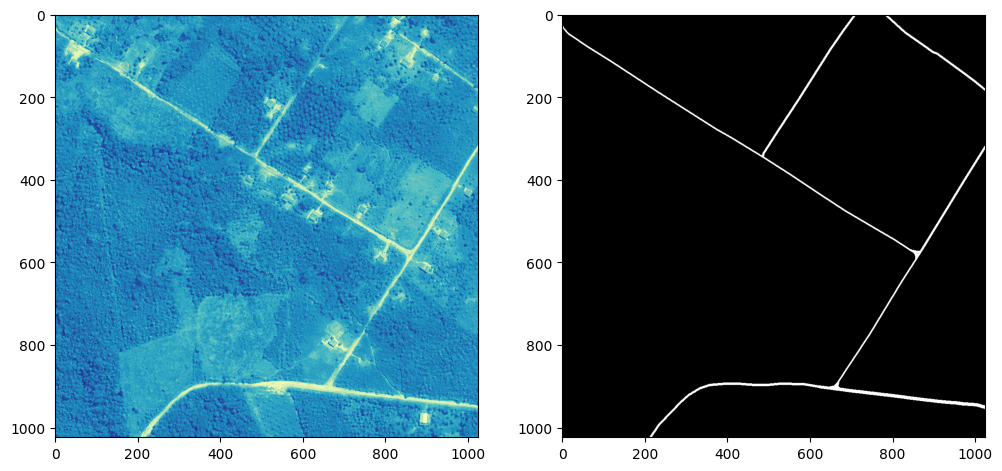

In [30]:
#Sanity check, view few mages
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='YlGnBu_r')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

-------

In [31]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [32]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [33]:
#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [34]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH )
print(IMG_CHANNELS)

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

1024
1024
1


In [35]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2023-10-25 19:29:42.815375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22319 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:c4:00.0, compute capability: 8.6


sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 64)       640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 1024, 64)       256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 64)       0         ['batch_normalizat

In [36]:
!nvidia-smi

Wed Oct 25 19:29:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:C4:00.0 Off |                  Off |
| 30%   31C    P2    61W / 230W |  22711MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 8,
                    verbose = 1,
                    epochs = 20,
                    validation_data = (X_test, y_test),
                    shuffle = False)

Epoch 1/20


2023-10-25 19:30:31.624513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-25 19:30:46.924537: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-25 19:30:47.016175: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-25 19:30:47.016207: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m